In [1]:
cd /workspace/fast-influence-functions

/workspace/fast-influence-functions


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import torch
import transformers
from tqdm import tqdm
from transformers import TrainingArguments
from transformers import default_data_collator
from transformers import AutoModelForSequenceClassification
from typing import Tuple, Dict, Any, Optional, List

from run_experiments import NUM_RETRAINING_EXPERIMENTS
from experiments import constants
from experiments import misc_utils
from experiments.data_utils import glue_output_modes
from experiments.mnli import (
    NUM_DATAPOINTS_TO_REMOVE_CHOICES,
    CORRECT_INDICES,
    INCORRECT_INDICES)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
tokenizer, _ = misc_utils.create_tokenizer_and_model(
    constants.MNLI_MODEL_PATH)

(_,
 mnli_eval_dataset) = misc_utils.create_datasets(
    task_name="mnli",
    tokenizer=tokenizer)

eval_instance_data_loader = misc_utils.get_dataloader(
    dataset=mnli_eval_dataset,
    batch_size=1,
    random=False)

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [5]:
def get_test_inputs_collections() -> List[int]:
    test_inputs_collections = {}
    for test_index, test_inputs in enumerate(eval_instance_data_loader):
        if test_index in (
                CORRECT_INDICES[:NUM_RETRAINING_EXPERIMENTS] +
                INCORRECT_INDICES[:NUM_RETRAINING_EXPERIMENTS]):

            test_inputs_collections[test_index] = test_inputs

    return test_inputs_collections

# Get the inputs collections
test_inputs_collections = get_test_inputs_collections()

In [6]:
EXPERIMENTS_BASE_DIR = "/export/home/hguo/Experiments/20201019"


def _load_model(
        mode: str,
        example_index: int,
        correct_mode: str,
        tag: str,
        num_data_points_to_remove: int
) -> Tuple[torch.nn.Module, transformers.Trainer]:
    if mode != "original":
        if mode in ["full"]:
            relative_dir = "full"
            hostname = "g0306.ll.unc.edu"

        if mode in ["KNN-1000", "KNN-10000"]:
            relative_dir = "KNN"
            hostname = "g0303.ll.unc.edu"

        if mode in ["random"]:
            relative_dir = "random"
            hostname = "g0310.ll.unc.edu"

        folder_name = (
            f"./retraining-remove-"
            f"{example_index}-"
            f"{correct_mode}-"
            f"{mode}-"
            f"{tag}-"
            f"{num_data_points_to_remove}"
            f".{hostname}"
        )

        model_dir = os.path.join(
            EXPERIMENTS_BASE_DIR,
            relative_dir,
            folder_name,
            "output_dir")
    else:
        if not all([
                example_index is None,
                correct_mode is None,
                tag is None,
                num_data_points_to_remove is None
        ]):
            raise ValueError

        model_dir = constants.MNLI_MODEL_PATH

    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()

    # Most of these arguments are placeholders
    # and are not really used at all, so ignore
    # the exact values of these.
    trainer = transformers.Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./tmp-output",
            per_device_train_batch_size=128,
            per_device_eval_batch_size=128,
            learning_rate=5e-5,
            logging_steps=100),
    )

    if model.training is True:
        raise ValueError
    
    print(f"Loading from {model_dir}")
    return model, trainer

def _compute_loss(
        trainer: transformers.Trainer,
        model: torch.nn.Module,
        inputs: Dict[str, Any],
) -> torch.Tensor:
    _, _, batch_mean_loss = misc_utils.predict(
        trainer=trainer,
        model=model,
        inputs=inputs)

    return batch_mean_loss


with tqdm(total=None) as pbar:
    loss_collections = []
    for mode in ["full", "KNN-1000", "KNN-10000", "random"]:
        for example_relative_index in range(NUM_RETRAINING_EXPERIMENTS):
            for correct_mode in ["correct", "incorrect"]:
                if correct_mode == "correct":
                    example_index = CORRECT_INDICES[example_relative_index]
                if correct_mode == "incorrect":
                    example_index = INCORRECT_INDICES[example_relative_index]

                if mode in ["full", "KNN-1000", "KNN-10000"]:
                    tags = ["helpful", "harmful"]

                elif mode in ["random"]:
                    tags = ["neutral", "entailment", "contradiction"]

                else:
                    raise ValueError

                for tag in tags:
                    for num_data_points_to_remove in NUM_DATAPOINTS_TO_REMOVE_CHOICES:
                        test_inputs = test_inputs_collections[example_index]

                        model, trainer = _load_model(
                            mode=mode,
                            example_index=example_index,
                            correct_mode=correct_mode,
                            tag=tag,
                            num_data_points_to_remove=num_data_points_to_remove)

                        loss = _compute_loss(
                            trainer=trainer,
                            model=model,
                            inputs=test_inputs)

                        loss_collections.append({
                            "mode": mode,
                            "correct_mode": correct_mode,
                            "example_index": example_index,
                            "tag": tag,
                            "num_data_points_to_remove": num_data_points_to_remove,
                            "loss": loss,
                        })

                        pbar.update(1)

0it [00:00, ?it/s]You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-helpful-1.g0306.ll.unc.edu/output_dir


1it [00:07,  7.45s/it]You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
2it [00:11,  6.30s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
3it [00:14,  5.48s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
4it [00:18,  4.86s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
5it [00:21,  4.46s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
6it [00:25,  4.17s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-0-correct-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
7it [00:28,  3.96s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-helpful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
8it [00:32,  3.84s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
9it [00:35,  3.75s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
10it [00:39,  3.66s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
11it [00:42,  3.62s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
12it [00:46,  3.59s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-3-incorrect-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
13it [00:49,  3.55s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-helpful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
14it [00:53,  3.55s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
15it [00:56,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
16it [01:00,  3.55s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
17it [01:03,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
18it [01:07,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-1-correct-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
19it [01:10,  3.51s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-helpful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
20it [01:14,  3.52s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
21it [01:17,  3.52s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
22it [01:21,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
23it [01:24,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
24it [01:28,  3.53s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-14-incorrect-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
25it [01:32,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-helpful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
26it [01:35,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
27it [01:39,  3.54s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
28it [01:42,  3.52s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
29it [01:46,  3.52s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
30it [01:49,  3.52s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-2-correct-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
31it [01:53,  3.51s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-helpful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
32it [01:56,  3.51s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-helpful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
33it [02:00,  3.51s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-helpful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
34it [02:03,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-harmful-1.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
35it [02:07,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-harmful-100.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
36it [02:10,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/full/./retraining-remove-15-incorrect-full-harmful-10000.g0306.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
37it [02:14,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
38it [02:17,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
39it [02:21,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
40it [02:24,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
41it [02:28,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
42it [02:31,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
43it [02:35,  3.50s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
44it [02:38,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
45it [02:41,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
46it [02:45,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
47it [02:48,  3.44s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
48it [02:52,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
49it [02:55,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
50it [02:59,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
51it [03:02,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
52it [03:06,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
53it [03:09,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
54it [03:13,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
55it [03:16,  3.44s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
56it [03:19,  3.43s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
57it [03:23,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
58it [03:26,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
59it [03:30,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
60it [03:33,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
61it [03:37,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
62it [03:40,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
63it [03:44,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
64it [03:47,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
65it [03:51,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
66it [03:54,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
67it [03:58,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
68it [04:01,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
69it [04:05,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
70it [04:08,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
71it [04:12,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
72it [04:15,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-1000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
73it [04:18,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
74it [04:22,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
75it [04:25,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
76it [04:29,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
77it [04:32,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
78it [04:36,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-0-correct-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
79it [04:39,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
80it [04:43,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
81it [04:46,  3.49s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
82it [04:50,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
83it [04:53,  3.44s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
84it [04:57,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-3-incorrect-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
85it [05:00,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
86it [05:04,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
87it [05:07,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
88it [05:11,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
89it [05:14,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
90it [05:18,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-1-correct-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
91it [05:21,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
92it [05:24,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
93it [05:28,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
94it [05:31,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
95it [05:35,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
96it [05:38,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-14-incorrect-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
97it [05:42,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
98it [05:45,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
99it [05:49,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
100it [05:52,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
101it [05:56,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
102it [05:59,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-2-correct-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
103it [06:03,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-helpful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
104it [06:06,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-helpful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
105it [06:10,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-helpful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
106it [06:13,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-harmful-1.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
107it [06:16,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-harmful-100.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
108it [06:20,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/KNN/./retraining-remove-15-incorrect-KNN-10000-harmful-10000.g0303.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
109it [06:23,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
110it [06:27,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
111it [06:30,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
112it [06:34,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
113it [06:37,  3.44s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
114it [06:41,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
115it [06:44,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
116it [06:48,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
117it [06:51,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-0-correct-random-contradiction-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
118it [06:54,  3.45s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
119it [06:58,  3.46s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
120it [07:01,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
121it [07:06,  3.90s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
122it [07:10,  3.73s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
123it [07:13,  3.62s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
124it [07:16,  3.53s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
125it [07:20,  3.47s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
126it [07:23,  3.43s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-3-incorrect-random-contradiction-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
127it [07:26,  3.40s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
128it [07:30,  3.38s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
129it [07:33,  3.37s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
130it [07:36,  3.36s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
131it [07:40,  3.35s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
132it [07:43,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
133it [07:46,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
134it [07:50,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
135it [07:53,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-1-correct-random-contradiction-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
136it [07:56,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
137it [08:00,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
138it [08:03,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
139it [08:06,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
140it [08:10,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
141it [08:13,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
142it [08:16,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
143it [08:20,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
144it [08:23,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-14-incorrect-random-contradiction-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
145it [08:26,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
146it [08:30,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
147it [08:33,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
148it [08:36,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
149it [08:40,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
150it [08:43,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
151it [08:46,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
152it [08:50,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
153it [08:53,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-2-correct-random-contradiction-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
154it [08:56,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-neutral-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
155it [09:00,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-neutral-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
156it [09:03,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-neutral-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
157it [09:06,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-entailment-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
158it [09:10,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-entailment-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
159it [09:13,  3.34s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-entailment-10000.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
160it [09:16,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-contradiction-1.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
161it [09:20,  3.33s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-contradiction-100.g0310.ll.unc.edu/output_dir


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.
162it [09:23,  3.48s/it]

Loading from /export/home/hguo/Experiments/20201019/random/./retraining-remove-15-incorrect-random-contradiction-10000.g0310.ll.unc.edu/output_dir


In [7]:
# example_index = 2
# correct_mode = "correct"
# mode = "KNN-10000"
# tag = "helpful"
# num_data_points_to_remove = 100

# model = _load_model(
#     example_index=example_index,
#     correct_mode=correct_mode,
#     mode=mode, tag=tag,
#     num_data_points_to_remove=num_data_points_to_remove)
# inputs = test_inputs_collections[0]

In [8]:
for example_relative_index in range(NUM_RETRAINING_EXPERIMENTS):
    for correct_mode in ["correct", "incorrect"]:
        if correct_mode == "correct":
            example_index = CORRECT_INDICES[example_relative_index]
        if correct_mode == "incorrect":
            example_index = INCORRECT_INDICES[example_relative_index]

        test_inputs = test_inputs_collections[example_index]

        model, trainer = _load_model(
            mode="original",
            example_index=None,
            correct_mode=None,
            tag=None,
            num_data_points_to_remove=None)

        loss = _compute_loss(
            trainer=trainer,
            model=model,
            inputs=test_inputs)

        loss_collections.append({
            "mode": "original",
            "correct_mode": correct_mode,
            "example_index": example_index,
            "tag": None,
            "num_data_points_to_remove": None,
            "loss": loss,
        })

        pbar.update(1)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Loading from /export/home/hguo/Experiments/20200706/


In [409]:
# torch.save(loss_collections, "/export/home/hguo/Experiments/20201102/loss_collections.20201102.pt")

In [320]:
import pandas as pd
loss_df = pd.DataFrame(loss_collections)

def _get_loss_diff(row):
    loss_diff = loss_df[
        (loss_df["mode"] == "original") &
        (loss_df["correct_mode"] == row["correct_mode"]) &
        (loss_df["example_index"] == row["example_index"])
    ]["loss"].values

    if loss_diff.shape != (1, ):
        raise ValueError

    return loss_diff[0]


loss_df["loss_diff"] = loss_df.apply(lambda row: row["loss"] - _get_loss_diff(row), axis=1)

if not (loss_df[loss_df["mode"] == "original"].loss_diff.values == 0.0).all():
    raise ValueError

loss_df

,mode,correct_mode,example_index,tag,num_data_points_to_remove,loss,loss_diff
0,full,correct,0,helpful,1.0,0.460587,0.068262
1,full,correct,0,helpful,100.0,0.566573,0.174249
2,full,correct,0,helpful,10000.0,5.615797,5.223472
3,full,correct,0,harmful,1.0,0.400037,0.007712
4,full,correct,0,harmful,100.0,0.283041,-0.109284
...,...,...,...,...,...,...,...
163,original,incorrect,3,None,NaN,0.759366,0.000000
164,original,correct,1,None,NaN,0.022249,0.000000
165,original,incorrect,14,None,NaN,2.864019,0.000000
166,original,correct,2,None,NaN,0.321906,0.000000


In [336]:
new_losses_mean = pd.DataFrame(
    loss_df[loss_df["mode"] != "original"]
    .groupby(["mode", "correct_mode", "tag", "num_data_points_to_remove"])
    ["loss_diff"].mean()
).to_dict()["loss_diff"]

new_losses_std = pd.DataFrame(
    loss_df[loss_df["mode"] != "original"]
    .groupby(["mode", "correct_mode", "tag", "num_data_points_to_remove"])
    ["loss_diff"].std()
).to_dict()["loss_diff"]

original_losses_mean = pd.DataFrame(
    loss_df[loss_df["mode"] == "original"]
    .groupby(["mode", "correct_mode"])
    ["loss_diff"].mean()
).to_dict()["loss_diff"]

original_losses_std = pd.DataFrame(
    loss_df[loss_df["mode"] == "original"]
    .groupby(["mode", "correct_mode"])
    ["loss_diff"].std()
).to_dict()["loss_diff"]

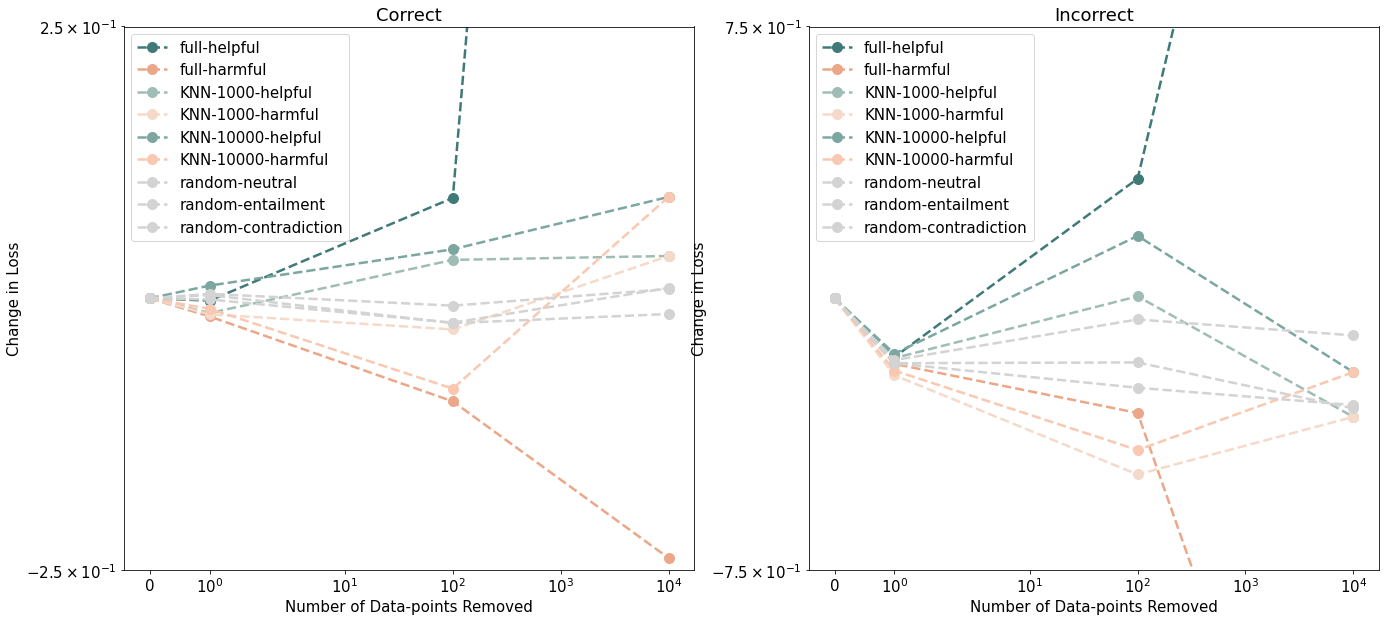

In [391]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22.5, 10)
plt.rcParams.update({"font.size": 15})
figure, axes = plt.subplots(1, 2, sharex=True)


for mode in ["full", "KNN-1000", "KNN-10000", "random"]:
    for axis_index, correct_mode in enumerate(["correct", "incorrect"]):
        if correct_mode == "correct":
            example_index = CORRECT_INDICES[example_relative_index]
        if correct_mode == "incorrect":
            example_index = INCORRECT_INDICES[example_relative_index]

        if mode in ["full", "KNN-1000", "KNN-10000"]:
            tags = ["helpful", "harmful"]

        elif mode in ["random"]:
            tags = ["neutral", "entailment", "contradiction"]

        else:
            raise ValueError

        for tag in tags:
            Xs = [0]# [0, 1, 100, 10000]
            Ys_mean = [original_losses_mean[("original", correct_mode)]]
            Ys_std_min = [
                original_losses_mean[("original", correct_mode)] -
                original_losses_std[("original", correct_mode)]
            ]
            Ys_std_max = [
                original_losses_mean[("original", correct_mode)] +
                original_losses_std[("original", correct_mode)]
            ]
            for num_data_points_to_remove in NUM_DATAPOINTS_TO_REMOVE_CHOICES:
                Xs.append(num_data_points_to_remove)
                Ys_mean.append(losses_mean[(
                    mode, correct_mode, tag, num_data_points_to_remove
                )])

                Ys_std_min.append(
                    losses_mean[(mode, correct_mode, tag, num_data_points_to_remove)] -
                    losses_std[(mode, correct_mode, tag, num_data_points_to_remove)]
                )
                Ys_std_max.append(
                    losses_mean[(mode, correct_mode, tag, num_data_points_to_remove)] +
                    losses_std[(mode, correct_mode, tag, num_data_points_to_remove)]
                )

            axes[axis_index].plot(
                Xs, Ys_mean,
                linestyle="--",
                marker="o",
                label=f"{mode}-{tag}",
                linewidth=2.5,
                markersize=10,
                color={
                    ("full", "helpful"): "#407A78",
                    ("KNN-10000", "helpful"): "#7CA6A0",
                    ("KNN-1000", "helpful"): "#9FBDB6",
                    ("full", "harmful"): "#EBA788",
                    ("KNN-10000", "harmful"): "#FAC8B1",
                    ("KNN-1000", "harmful"): "#F5DAC9",
                    ("random", "neutral"): "lightgrey",
                    ("random", "entailment"): "lightgrey",
                    ("random", "contradiction"): "lightgrey",
                }[(mode, tag)])
            axes[axis_index].legend()
            axes[axis_index].set_xscale("symlog")
            axes[axis_index].set_yscale("symlog")
            axes[axis_index].set_xlabel("Number of Data-points Removed")
            axes[axis_index].set_ylabel("Change in Loss")
            axes[axis_index].set_title(f"{correct_mode.capitalize()}")
            if correct_mode == "correct":
                axes[axis_index].set_ylim(top=0.25, bottom=-0.25)
            else:
                axes[axis_index].set_ylim(top=0.75, bottom=-0.75)

# figure.savefig("./20201102-retraining.pdf")

In [382]:
# for column, correct_mode in enumerate(["correct", "incorrect"]):
#     for mode in ["full", "KNN-1000", "KNN-10000"]:
#         for row, tag in enumerate(["helpful", "harmful"]):

#     for random_label in ["neutral", "entailment", "contradiction"]:
#         Xs = [0, 1, 2, 3]# [0, 1, 100, 10000]
#         Ys_mean = [
#             original_losses_mean[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] for n in [1, 100, 10000]
#         ]

#         Ys_std_min = [
#             original_losses_mean[("original", correct_mode)] -
#             original_losses_std[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] -
#             losses_std[("random", correct_mode, random_label, n)]
#             for n in [1, 100, 10000]
#         ]

#         Ys_std_max = [
#             original_losses_mean[("original", correct_mode)] +
#             original_losses_std[("original", correct_mode)]
#         ] + [
#             losses_mean[("random", correct_mode, random_label, n)] +
#             losses_std[("random", correct_mode, random_label, n)]
#             for n in [1, 100, 10000]
#         ]
#         axes[column].plot(Xs, Ys_mean, label=f"{random_label}", linestyle="--")
#         axes[column].legend()
#         if correct_mode == "correct":
#             axes[column].set_ylim(top=0.2, bottom=-0.25)
#         else:
#             axes[column].set_ylim(top=0.25, bottom=-0.5)
#         axes[column].set_title(f"{correct_mode}")

In [145]:
# for mode in ["full", "KNN-1000", "KNN-10000"]:
#     Xs = [0, 1, 100, 10000]
#     Ys = [
#         original_losses_mean[("original", "correct")]
#     ] + [
#         losses_mean[(mode, "incorrect", "harmful", n)] for n in [1, 100, 10000]
#     ]
#     plt.plot(Xs, Ys, label=mode)

# plt.legend()
# plt.xscale("log")